In [1]:
import tensorflow as tf
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
# Mounted google drive at session storage
 
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
import pathlib
import zipfile
 
#Modify next line according to your drive location or local os path
 
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Classroom/Artificial Intelligence-07B1/Cats vs Dogs Image Classification/train_ds.zip", 'r')
zip_ref.extractall("/content/data/train")  # extracted data from zip file 'train_ds.zip'
 
data_dir = pathlib.Path("/content/data/train/train")  # store path of train dataset
zip_ref.close()

In [4]:
data_dir

PosixPath('/content/data/train/train')

In [5]:
# total image count

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

25000


In [6]:
batch_size = 32
 
# resize all images to size (180,180)
img_height = 180
img_width = 180
 
# Create training set from images directory using keras.preprocessing
 
train_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [7]:
# Create validation set from images directory (train - 0.8, validation - 0.2)
 
val_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [8]:
classes = train_ds.class_names
print(classes)

['cat', 'dog']


In [11]:
for images, labels in train_ds:
  images_shape = images.shape
  labels_shape = labels.shape
  print(images.shape)
  print(labels.shape)
  print(type(images))
  break

(32, 180, 180, 3)
(32,)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [12]:
for images, labels in val_ds:
  print(images.shape)
  print(labels.shape)
  break

(32, 180, 180, 3)
(32,)


In [13]:
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
# try to use ImageDataGenerator (Data augmentation e.g random flips, crops..) to improve accuracy


In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

In [16]:
# Define the model architecture
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

data_augmentation = Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(180, 180, 3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

model = Sequential()
model.add(data_augmentation)
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))) # Normalize the dataset to improve accuracy
 
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())  
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [17]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [18]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [19]:
# callbacks used to prevent model from diverging and reduce learning rate (by factor of 0.5) as we approach minima
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
earlystop = EarlyStopping(patience=10)
 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
 
callbacks = [earlystop, learning_rate_reduction]

In [20]:
try:
    history = model.fit(train_ds,
                    validation_data = val_ds,
                    validation_steps = 157,
                    epochs = 25,
                    callbacks = callbacks,
                    verbose=1,
                    )
except KeyboardInterrupt:
    pass

Epoch 1/25
625/625 [==============================] - 48s 77ms/step - loss: 0.6221 - accuracy: 0.6515 - val_loss: 0.5330 - val_accuracy: 0.7346
Epoch 2/25
625/625 [==============================] - 49s 78ms/step - loss: 0.5404 - accuracy: 0.7261 - val_loss: 0.5028 - val_accuracy: 0.7554
Epoch 3/25
625/625 [==============================] - 51s 82ms/step - loss: 0.5045 - accuracy: 0.7508 - val_loss: 0.4689 - val_accuracy: 0.7722
Epoch 4/25
625/625 [==============================] - 48s 77ms/step - loss: 0.4802 - accuracy: 0.7690 - val_loss: 0.4558 - val_accuracy: 0.7802
Epoch 5/25
625/625 [==============================] - 49s 79ms/step - loss: 0.4601 - accuracy: 0.7851 - val_loss: 0.4307 - val_accuracy: 0.7990
Epoch 6/25
625/625 [==============================] - 49s 79ms/step - loss: 0.4445 - accuracy: 0.7936 - val_loss: 0.4321 - val_accuracy: 0.7998
Epoch 7/25
625/625 [==============================] - 50s 80ms/step - loss: 0.4276 - accuracy: 0.8020 - val_loss: 0.4302 - val_accuracy:

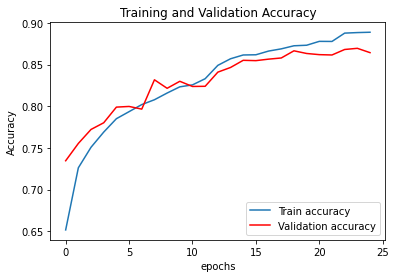

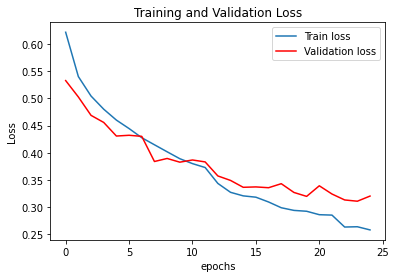

<Figure size 432x288 with 0 Axes>

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], color='red')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(['Train accuracy', 'Validation accuracy'], loc = 'lower right')
plt.show()
plt.savefig('accuracy.png')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='red')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(['Train loss', 'Validation loss'], loc = 'upper right')
plt.show()
plt.savefig('loss.png')

In [29]:
#serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


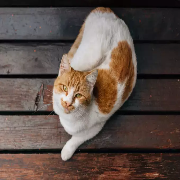


This image most likely belongs to cat with a 94.82% confidence.


In [40]:
import cv2
from google.colab.patches import cv2_imshow
test_img = cv2.imread('/content/test_img.webp')
test_img = cv2.resize(test_img, (180,180))
cv2_imshow(test_img)
test_img = test_img.reshape((1,180,180,3))
pred = model.predict(test_img)
print(
    "\nThis image most likely belongs to {} with a {:.2f}% confidence."
    .format(classes[np.argmax(pred)], 100 * np.max(pred))
)